## Task intro

Задача - определение оттока абонентов с повышенным потреблением. Характеристика абонентов: b2c, время жизни больше 90 дней, с LTD < 1 (last_trans_date), ARPU за 4 недели >= 500. Оттоком считаем LTD >=7.

Предикторы считались за 3 месяца до выбранной даты, целевая переменная - на месяце после. 

In [1]:
import pandas as pd
import numpy as np
from pyhive import hive
import warnings
warnings.filterwarnings('ignore')
from datetime import timedelta, date
from sklearn import metrics
import pickle
import time
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

In [2]:
!kinit -kt edtolstov.keytab edtolstov
!klist

Ticket cache: FILE:/tmp/krb5cc_815720870
Default principal: edtolstov@BEE.VIMPELCOM.RU

Valid starting       Expires              Service principal
04/05/2019 13:05:25  04/05/2019 23:05:25  krbtgt/BEE.VIMPELCOM.RU@BEE.VIMPELCOM.RU
	renew until 04/12/2019 13:05:25


In [3]:
conn = hive.Connection(host = "hd-has014.vimpelcom.ru", port = "10000", username = "edtolstov", database = "arstel", 
                       auth = "KERBEROS", kerberos_service_name = "hive", configuration = {'job.queue.name': 'adhoc'})
cursor = conn.cursor()

In [4]:
s00='''set mapred.job.queue.name=adhoc'''
cursor.execute(s00)

## Data load

In [6]:
# Определяем временные промежутки

import datetime

today = date.today()

time_start = today - timedelta(days = today.weekday(), weeks = 12)
time_end=time_start+timedelta(days = 28)
time_m1=time_start-timedelta(days = 30)
time_m2=time_start-timedelta(days = 60)
time_m3=time_start-timedelta(days = 90)

time_start1 = ("'P" + str(time_start.year).zfill(4) + str(time_start.month).zfill(2) + 
                 str(time_start.day).zfill(2) + "'")
time_end1 = ("'P" + str(time_end.year).zfill(4) + str(time_end.month).zfill(2) + 
                 str(time_end.day).zfill(2) + "'")
time_m1_1 = ("'P" + str(time_m1.year).zfill(4) + str(time_m1.month).zfill(2) + 
                 str(time_m1.day).zfill(2) + "'")
time_m2_1 = ("'P" + str(time_m2.year).zfill(4) + str(time_m2.month).zfill(2) + 
                 str(time_m2.day).zfill(2) + "'")
time_m3_1 = ("'P" + str(time_m3.year).zfill(4) + str(time_m3.month).zfill(2) + 
                 str(time_m3.day).zfill(2) + "'")

time_min = today - timedelta(days = today.weekday(), weeks = 27)# 15
time_min = ("'P" + str(time_min.year).zfill(4) + str(time_min.month).zfill(2) + 
                 str(time_min.day).zfill(2) + "'")

# -------------------------------------------------
time_start2 = ("'" + str(time_start.year).zfill(4) + '-' + str(time_start.month).zfill(2) + '-' + 
                 str(time_start.day).zfill(2) + "'")

time_end2 = ("'" + str(time_end.year).zfill(4) + '-' + str(time_end.month).zfill(2) + '-' + 
                 str(time_end.day).zfill(2) + "'")

time_m1_2 = ("'" + str(time_m1.year).zfill(4)  + '-' + str(time_m1.month).zfill(2) + '-' + 
                 str(time_m1.day).zfill(2) + "'")

time_m2_2 = ("'" + str(time_m2.year).zfill(4)  + '-' + str(time_m2.month).zfill(2) + '-' + 
                 str(time_m2.day).zfill(2) + "'")

time_m3_2 = ("'" + str(time_m3.year).zfill(4)  + '-' + str(time_m3.month).zfill(2) + '-' + 
                 str(time_m3.day).zfill(2) + "'")


print(time_start1, time_end1, time_m1_1, time_m2_1, time_m3_1, time_min)
print(time_start2,time_end2,time_m1_2,time_m2_2,time_m3_2)

'P20190107' 'P20190204' 'P20181208' 'P20181108' 'P20181009' 'P20180924'
'2019-01-07' '2019-02-04' '2018-12-08' '2018-11-08' '2018-10-09'


In [7]:
s1 = '''
create table customer360_dev.edt_mf_churn_new_feats_full_mnp as
with mnp_t as 
(
select 
case 
when length(ctn) = 11 and substr(ctn, 1, 1) in ('7', '8') 
then substr(ctn, 2, 10) else ctn 
end as ctn, ban, 
min(req_created) as req_created,
max(operator_code) as operator_code
from mnp.requests 
WHERE process_type = 'PortOut'
AND status NOT LIKE 'CNCL%'
AND status NOT LIKE 'DRFT%'

and req_created >= {time_m3_2}
and req_created <  {time_start2}
group by 
case 
when length(ctn) = 11 and substr(ctn, 1, 1) in ('7', '8') 
then substr(ctn, 2, 10) else ctn 
end, ban
)
,t2 as (
select
topten.ctn as subs_key,
case when length(all_topten1) = 11 and substr(all_topten1, 1, 1) in ('7', '8') 
then substr(all_topten1, 2, 10) else all_topten1 
end as all_topten1

from customer360.stg_contacts_top10_monthly topten
LATERAL VIEW explode(all_topten) adTable as all_topten1
where 1=1
and topten.time_key >= {time_m3_2}
and topten.time_key <  {time_start2}
)
,mnp_top10 as (
select

t2.subs_key,

collect_list(case when mnp_t.req_created is null then 0 else 1 end) as mnp_ind_lst, 
collect_list(mnp_t.operator_code) as operator_lst,
collect_list(mnp_t.ctn) as mnp_lst

from t2 
left join mnp_t 
ON t2.all_topten1 = mnp_t.ctn
group by t2.subs_key
)

select pt.time_key,pt.subs_key,pt.ban_key,pt.market_key,
price_plan_key,pp_archetype,
i2,last_balance,p115,p127,p21,p37,p66,t29,t39,t63,p137,
t294,
p118,p119,p123,
k3,v42, 
V63,
M1_ARPU,ALL_M3_ARPU,M1_VOICE_UNIQUE_SUBS,M1_OUTGOING,M3_OUTGOING,M1_INCOMING,M3_INCOMING,M1_INACTIVITY,M3_INACTIVITY
,M1_OUTGOING+M1_INCOMING                          as M1_VOICE_TOTAL
,M3_OUTGOING+M3_INCOMING                          as M3_VOICE_TOTAL
,M1_OUTGOING+M1_INCOMING-M3_OUTGOING-M3_INCOMING  as delta_voice_total
,M1_INACTIVITY-M3_INACTIVITY                      as delta_inactivity
,(M1_ARPU/ALL_M3_ARPU)*3                          as ARPU_RECENCY_3M
,power(((M1_OUTGOING+M1_INCOMING)/(M3_OUTGOING+M3_INCOMING)), 0.333333) as VOICE_TOTAL_CAGR_3M
,m.multi2_prob_top
,d6.age_category

,tar.ltd

,badcl3.tot_data_traf_m as tot_data_traf_m_m3 
,badcl3.tot_voice_traf_m as tot_voice_traf_m_m3 
,badcl3.data_badcell_m as data_badcell_m_m3 
,badcl3.voice_badcell_m as voice_badcell_m_m3 
,badcl3.data_badcell_share as data_badcell_share_m3 
,badcl3.voice_badcell_share as voice_badcell_share_m3 
,badcl3.bad_data_ind_str as bad_data_ind_str_m3 
,badcl3.bad_voice_ind_str as bad_voice_ind_str_m3 
,badcl3.bad_data_ind_low as bad_data_ind_low_m3 
,badcl3.bad_voice_ind_low as bad_voice_ind_low_m3

,badcl2.tot_data_traf_m as tot_data_traf_m_m2 
,badcl2.tot_voice_traf_m as tot_voice_traf_m_m2 
,badcl2.data_badcell_m as data_badcell_m_m2 
,badcl2.voice_badcell_m as voice_badcell_m_m2 
,badcl2.data_badcell_share as data_badcell_share_m2 
,badcl2.voice_badcell_share as voice_badcell_share_m2 
,badcl2.bad_data_ind_str as bad_data_ind_str_m2 
,badcl2.bad_voice_ind_str as bad_voice_ind_str_m2 
,badcl2.bad_data_ind_low as bad_data_ind_low_m2 
,badcl2.bad_voice_ind_low as bad_voice_ind_low_m2 

,badcl1.tot_data_traf_m as tot_data_traf_m_m1 
,badcl1.tot_voice_traf_m as tot_voice_traf_m_m1 
,badcl1.data_badcell_m as data_badcell_m_m1 
,badcl1.voice_badcell_m as voice_badcell_m_m1 
,badcl1.data_badcell_share as data_badcell_share_m1 
,badcl1.voice_badcell_share as voice_badcell_share_m1 
,badcl1.bad_data_ind_str as bad_data_ind_str_m1 
,badcl1.bad_voice_ind_str as bad_voice_ind_str_m1 
,badcl1.bad_data_ind_low as bad_data_ind_low_m1 
,badcl1.bad_voice_ind_low as bad_voice_ind_low_m1


,device1.distinct_tac


,mnp_t.req_created
,mnp_t.operator_code

,mnp_top10.mnp_ind_lst
,mnp_top10.operator_lst
,mnp_top10.mnp_lst

,case when tar.ltd <7 then 0 else 1 end as target

from

(select 
 time_key,subs_key,ban_key,market_key , P66 as LTD2_CURR, 
 price_plan_key,pp_archetype,
 i2,last_balance,p115,p127,p21,p37,p66,t29,t39,t63,p137
 from datamart.agg_pm_kpi_weekly_prp_pt p
         left join biis.dim_price_plan n
         on p.i1 = n.price_plan_key 
    where time_key= {time_start1} and i2>=90 and P66 >= 0  and P66 <= 1 and p36>=500  and 
          n.pp_archetype in ('B2C Bundle', 'B2C Bundle Unlim','B2C LowBundle', 
                              'B2C VAS', 'B2C archive', 'B2C flat','B2C onnet',   
                    'B2C other', 'CIS','SEBDONOR','B2C Bundle Conv','SEBDONOR Conv')) pt

left join     
  (select
    time_key,subs_key,ban_key,market_key,t294
    from datamart.agg_pm_kpi_weekly_prp_pt_2
    where time_key= {time_start1}) pt_2
on      pt.subs_key=pt_2.subs_key and pt.ban_key=pt_2.ban_key and pt.market_key=pt_2.market_key

left join
  (select
    time_key,subs_key,ban_key,market_key,p118,p119,p123
    from datamart.agg_pm_kpi_weekly_prp_pt_3
    where time_key={time_start1}  ) pt_3
 on    pt.subs_key=pt_3.subs_key and pt.ban_key=pt_3.ban_key and pt.market_key=pt_3.market_key 

left join     
  (select
    time_key,subs_key,ban_key,market_key,k3,v42
    from datamart.agg_pm_kpi_weekly_prp_iksvc
    where time_key={time_start1}  ) iksvc
on      pt.subs_key=iksvc.subs_key and pt.ban_key=iksvc.ban_key and pt.market_key=iksvc.market_key  

left join 
(select
    time_key,subs_key,ban_key,market_key,V63
    from datamart.agg_pm_kpi_weekly_prp_iksvc_4
    where time_key={time_start1} ) iksvc_4
on      pt.subs_key=iksvc_4.subs_key and pt.ban_key=iksvc_4.ban_key and pt.market_key=iksvc_4.market_key

left join
(select 
 subs_key,ban_key,market_key,
 sum(case when time_key >= {time_m1_1} and time_key <={time_start1}    then P22 else 0 end) as M1_ARPU,
 sum(case when time_key >= {time_m3_1} and time_key <={time_start1}    then P22 else 0 end) as ALL_M3_ARPU,
 sum(case when time_key >= {time_m1_1} and time_key <={time_start1}    then T124 else 0 end) as M1_VOICE_UNIQUE_SUBS,
 sum(case when time_key >= {time_m1_1} and time_key <={time_start1}    then T48 else 0 end) as M1_OUTGOING,
 sum(case when time_key >= {time_m3_1} and time_key <={time_m2_1}       then T48 else 0 end) as M3_OUTGOING,
 sum(case when time_key >= {time_m1_1} and time_key <={time_start1}    then T59 else 0 end) as M1_INCOMING,
 sum(case when time_key >= {time_m3_1} and time_key <={time_m2_1}       then T59 else 0 end) as M3_INCOMING,
 sum(case when time_key >= {time_m1_1} and time_key <={time_start1}   
     then (case when P66 <= 7 then p66 else 7 end) else 0 end) as M1_INACTIVITY,
 sum(case when time_key >= {time_m3_1} and time_key <= {time_m2_1}
     then (case when P66 <= 7 then p66 else 7 end) else 0 end) as M3_INACTIVITY

from  datamart.AGG_PM_KPI_WEEKLY_PRP_PT  where(TIME_KEY >= {time_min} and TIME_KEY <= {time_start1})
group by subs_key,ban_key,market_key ) d4
 on    pt.subs_key=d4.subs_key and pt.ban_key=d4.ban_key and pt.market_key=d4.market_key

left join 
(select subs_key,ban_key,market_key, avg(multi2_prob_top) as multi2_prob_top
from  cvm.scoring_multisim_2_5_history
 where multi2_prob is not null
and date_key >={time_m1_2}
    and date_key < {time_start2}
     group by subs_key,ban_key,market_key
 ) m
on pt.subs_key=m.subs_key and pt.ban_key=m.ban_key and pt.market_key=m.market_key

left join
(
select subs_key, ban_key,market_key, max(age_category) as age_category
from SPP.AGG_MODEL_AGE_MONTHLY
where time_key >={time_m3_2}
and time_key <= {time_start2}
group by subs_key, ban_key,market_key
) d6

on pt.subs_key=d6.subs_key and pt.ban_key=d6.ban_key and pt.market_key=d6.market_key

left join
(select SUBS_KEY, BAN_KEY, MARKET_KEY, P66 AS LTD
FROM datamart.AGG_PM_KPI_WEEKLY_PRP_PT 
where TIME_KEY = {time_end1}  ) tar
on pt.subs_key=tar.subs_key and pt.ban_key=tar.ban_key and pt.market_key=tar.market_key

left join
(
select 
ctn, ban_key,
avg(tot_data_traf_m) as tot_data_traf_m, 
avg(tot_voice_traf_m) as tot_voice_traf_m,

avg(data_badcell_m) as data_badcell_m, 
avg(voice_badcell_m) as voice_badcell_m, 

avg(data_badcell_share) as data_badcell_share, 
avg(voice_badcell_share) as voice_badcell_share, 

avg(bad_data_ind_str) as bad_data_ind_str, 
avg(bad_voice_ind_str) as bad_voice_ind_str, 
avg(bad_data_ind_low) as bad_data_ind_low, 
avg(bad_voice_ind_low) as bad_voice_ind_low 

from customer360.stg_badcell_weekly
where 1=1
and time_key >={time_m3_2}
and time_key < {time_m2_2}

group by ctn, ban_key
) badcl3
on pt.subs_key = badcl3.ctn and pt.ban_key=badcl3.ban_key

left join
(
select 
ctn, ban_key,
avg(tot_data_traf_m) as tot_data_traf_m, 
avg(tot_voice_traf_m) as tot_voice_traf_m,

avg(data_badcell_m) as data_badcell_m, 
avg(voice_badcell_m) as voice_badcell_m, 

avg(data_badcell_share) as data_badcell_share, 
avg(voice_badcell_share) as voice_badcell_share, 

avg(bad_data_ind_str) as bad_data_ind_str, 
avg(bad_voice_ind_str) as bad_voice_ind_str, 
avg(bad_data_ind_low) as bad_data_ind_low, 
avg(bad_voice_ind_low) as bad_voice_ind_low 

from customer360.stg_badcell_weekly
where 1=1
and time_key >={time_m2_2}
and time_key < {time_m1_2}

group by ctn, ban_key
) badcl2
on pt.subs_key = badcl2.ctn and pt.ban_key=badcl2.ban_key

left join
(
select 
ctn, ban_key,
avg(tot_data_traf_m) as tot_data_traf_m, 
avg(tot_voice_traf_m) as tot_voice_traf_m,

avg(data_badcell_m) as data_badcell_m, 
avg(voice_badcell_m) as voice_badcell_m, 

avg(data_badcell_share) as data_badcell_share, 
avg(voice_badcell_share) as voice_badcell_share, 

avg(bad_data_ind_str) as bad_data_ind_str, 
avg(bad_voice_ind_str) as bad_voice_ind_str, 
avg(bad_data_ind_low) as bad_data_ind_low, 
avg(bad_voice_ind_low) as bad_voice_ind_low 

from customer360.stg_badcell_weekly
where 1=1
and time_key >={time_m1_2}
and time_key < {time_start2}

group by ctn, ban_key
) badcl1
on pt.subs_key = badcl1.ctn and pt.ban_key=badcl1.ban_key

left join
(select CTN, count (distinct tac) as distinct_tac
FROM customer360.stg_device_changed
where 1=1
and time_key >={time_m3_2}
and time_key < {time_start2}

group by CTN 
) device1
on pt.subs_key=device1.ctn

left join mnp_t
on pt.subs_key = mnp_t.ctn and pt.ban_key=mnp_t.ban

left join mnp_top10
on pt.subs_key = mnp_top10.subs_key 

'''.format(time_start1 = time_start1,
time_end1 = time_end1,
time_m1_1 = time_m1_1,
time_m2_1 = time_m2_1,
time_m3_1 = time_m3_1,
time_min = time_min,
time_start2 = time_start2,
time_end2 = time_end2,
time_m1_2 = time_m1_2,
time_m2_2 = time_m2_2,
time_m3_2 = time_m3_2)

s1 = s1.replace('\n',' ')

In [8]:
%%time
cursor.execute(s1)

CPU times: user 49.2 ms, sys: 28.3 ms, total: 77.5 ms
Wall time: 1h 59min 42s


### Making sample


In [11]:
%%time

s2 = '''
create table customer360_dev.edt_mf_churn_new_feats_full_mnp_samp as
select 
a.*
from customer360_dev.edt_mf_churn_new_feats_full_mnp a
distribute by rand()
sort by rand()
limit 500000 
'''
cursor.execute(s2)

CPU times: user 14.4 ms, sys: 10.3 ms, total: 24.7 ms
Wall time: 13min 3s


In [6]:
%%time

s1 = "select * from arstel.edt_mf_churn_new_feats_full_mnp_samp"

s1 = s1.replace('\n',' ')

telcom = pd.read_sql(s1, conn)

CPU times: user 1min 39s, sys: 1.48 s, total: 1min 41s
Wall time: 2min 4s


### Preparing data

In [9]:
telcom.columns=['time_key',
'subs_key',
'ban_key',
'market_key',
'price_plan_key',
'pp_archetype',
'i2',
'last_balance',
'p115',
'p127',
'p21',
'p37',
'p66',
't29',
't39',
't63',
'p137',
't294',
'p118',
'p119',
'p123',
'k3',
'v42',
'v63',
'm1_arpu',
'all_m3_arpu',
'm1_voice_unique_subs',
'm1_outgoing',
'm3_outgoing',
'm1_incoming',
'm3_incoming',
'm1_inactivity',
'm3_inactivity',
'm1_voice_total',
'm3_voice_total',
'delta_voice_total',
'delta_inactivity',
'arpu_recency_3m',
'voice_total_cagr_3m',
'multi2_prob_top',
'age_category',
'ltd',
'tot_data_traf_m_m3',
'tot_voice_traf_m_m3',
'data_badcell_m_m3',
'voice_badcell_m_m3',
'data_badcell_share_m3',
'voice_badcell_share_m3',
'bad_data_ind_str_m3',
'bad_voice_ind_str_m3',
'bad_data_ind_low_m3',
'bad_voice_ind_low_m3',
'tot_data_traf_m_m2',
'tot_voice_traf_m_m2',
'data_badcell_m_m2',
'voice_badcell_m_m2',
'data_badcell_share_m2',
'voice_badcell_share_m2',
'bad_data_ind_str_m2',
'bad_voice_ind_str_m2',
'bad_data_ind_low_m2',
'bad_voice_ind_low_m2',
'tot_data_traf_m_m1',
'tot_voice_traf_m_m1',
'data_badcell_m_m1',
'voice_badcell_m_m1',
'data_badcell_share_m1',
'voice_badcell_share_m1',
'bad_data_ind_str_m1',
'bad_voice_ind_str_m1',
'bad_data_ind_low_m1',
'bad_voice_ind_low_m1',
'distinct_tac',

'req_created',
'operator_code',
'mnp_ind_lst',
'operator_lst',
'mnp_lst',
'target']

## Data prep & feature engineering

In [ ]:
#1. badcell prep

In [10]:
telcom['data_badcell_m_m3']=telcom['data_badcell_m_m3']/1000000
telcom['data_badcell_m_m2']=telcom['data_badcell_m_m2']/1000000
telcom['data_badcell_m_m1']=telcom['data_badcell_m_m1']/1000000

telcom['tot_data_traf_m_m1']=telcom['tot_data_traf_m_m1']/1000000
telcom['tot_data_traf_m_m2']=telcom['tot_data_traf_m_m2']/1000000
telcom['tot_data_traf_m_m3']=telcom['tot_data_traf_m_m3']/1000000

In [11]:
#агрегируем по 3 месяцам 

telcom["data_badcell_all"] = (telcom['data_badcell_m_m3'] + telcom['data_badcell_m_m2'] + telcom['data_badcell_m_m1'])/3
telcom["voice_badcell_all"] = (telcom['voice_badcell_m_m3'] + telcom['voice_badcell_m_m2'] + telcom['voice_badcell_m_m1'])/3

telcom["data_badcell_min"] = telcom.loc[:, ['data_badcell_m_m3', 'data_badcell_m_m2', 'data_badcell_m_m1']].min(axis=1)
telcom["data_badcell_max"] = telcom.loc[:, ['data_badcell_m_m3', 'data_badcell_m_m2', 'data_badcell_m_m1']].max(axis=1)

telcom["voice_badcell_min"] = telcom.loc[:, ['voice_badcell_m_m3', 'voice_badcell_m_m2', 'voice_badcell_m_m1']].min(axis=1)
telcom["voice_badcell_max"] = telcom.loc[:, ['voice_badcell_m_m3', 'voice_badcell_m_m2', 'voice_badcell_m_m1']].max(axis=1)

#trends
telcom['data_badcell_chng'] = (telcom['data_badcell_m_m3']/telcom['data_badcell_m_m2'] + telcom['data_badcell_m_m2']/telcom['data_badcell_m_m1'])/2
telcom['voice_badcell_chng'] = (telcom['voice_badcell_m_m3']/telcom['voice_badcell_m_m2'] + telcom['voice_badcell_m_m2']/telcom['voice_badcell_m_m1'])/2

telcom['data_badcell_trend'] = ((telcom['data_badcell_m_m3']/telcom['data_badcell_m_m2'] + telcom['data_badcell_m_m2']/telcom['data_badcell_m_m1'])/2)-1
telcom['voice_badcell_trend'] = ((telcom['voice_badcell_m_m3']/telcom['voice_badcell_m_m2'] + telcom['voice_badcell_m_m2']/telcom['voice_badcell_m_m1'])/2)-1

In [10]:
#2. device 

In [12]:
telcom['tac_changed_flg'] = np.where(telcom['distinct_tac']>1, 1, 0)

In [12]:
#3. MNP

In [13]:
telcom['row_length'] = telcom['mnp_lst'].str.len()

def flag_df(df):
    
    if (df['row_length'] <=2):
        return 0
    elif (df['row_length'] > 2) and (df['row_length'] <=27):
        return 1
    elif (df['row_length'] > 27):
        return 2

telcom['mnp_cnt'] = telcom.apply(flag_df, axis = 1)

In [14]:
telcom['mnp_top10_flg'] = np.where(telcom['mnp_cnt']> 0, 1, 0)

In [15]:
#self mnp 
telcom['mnp_self_flg'] = np.where(telcom['req_created'].notnull(),1,0)

## Model fit

#new feats

1. mnp_top10_flg
2. mnp_cnt
3. operator_lst (categorical)

4. mnp_self_flg

In [16]:
feat = [
'market_key',
'age_category',
'price_plan_key',
'pp_archetype',
'p137',
'operator_lst',

'm1_voice_total',
'm3_voice_total',
'delta_voice_total',
'delta_inactivity',
'arpu_recency_3m',
'voice_total_cagr_3m',
'm1_arpu',
'all_m3_arpu',
'm1_voice_unique_subs',
'm1_outgoing',
'm3_outgoing',
'm1_incoming',
'm3_incoming',
'm1_inactivity',
'm3_inactivity',
'i2',
'last_balance',
'p115',
'p127',
'p21',
'p37',
'p66',
't29',
't39',
't63',
't294',
'p118',
'p119',
'p123', 
'multi2_prob_top'

,'tot_data_traf_m_m1'
,'data_badcell_m_m1'
,'data_badcell_share_m1'    
,'voice_badcell_m_m2'
,'voice_badcell_m_m1'
,'voice_badcell_share_m1'
,"data_badcell_all"
,"voice_badcell_all"
,"data_badcell_min"
,"data_badcell_max"
,"voice_badcell_min"
,"voice_badcell_max"
,'data_badcell_chng'
,'voice_badcell_chng'
,'data_badcell_trend'
,'voice_badcell_trend'

,'distinct_tac'
,'tac_changed_flg'
    
,'mnp_top10_flg'
,'mnp_cnt'
,'mnp_self_flg'
]

In [ ]:
#find NA

In [17]:
X = telcom[feat]
X['age_category'] = X['age_category'].fillna(0)
X['operator_lst'] = X['operator_lst'].fillna(0)
X['mnp_cnt'] = X['mnp_cnt'].fillna(0)

Y = telcom['target']

x_train_all, x_test_all, y_train_all, y_test_all = train_test_split(X, Y, test_size = 0.3)
cat_features=[0,1,2,3,4,5]

In [18]:
# target balance

y=Y

print('Labels: {}'.format(set(y)))
print('Zero count = {}, One count = {}'.format(len(y) - sum(y), sum(y)))
print('Diff = {}'.format(sum(y)/(len(y) - sum(y))))

Labels: {0, 1}
Zero count = 490375, One count = 9625
Diff = 0.01962783583991843


In [20]:
%%time
model = ( CatBoostClassifier(iterations = 1000, depth = 5, learning_rate = 0.03, rsm = 0.9, 
                       loss_function = 'Logloss', 
                       custom_loss = ['AUC', 'Recall', 'Precision'], random_seed = 7 , use_best_model=True))

model.fit(x_train_all, y_train_all,cat_features,
          eval_set=(x_test_all,y_test_all),
          plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6315180	test: 0.6315457	best: 0.6315457 (0)	total: 237ms	remaining: 3m 56s
1:	learn: 0.5765014	test: 0.5765540	best: 0.5765540 (1)	total: 408ms	remaining: 3m 23s
2:	learn: 0.5273672	test: 0.5275135	best: 0.5275135 (2)	total: 590ms	remaining: 3m 15s
3:	learn: 0.4831491	test: 0.4833183	best: 0.4833183 (3)	total: 763ms	remaining: 3m 9s
4:	learn: 0.4440746	test: 0.4442582	best: 0.4442582 (4)	total: 938ms	remaining: 3m 6s
5:	learn: 0.4088185	test: 0.4090459	best: 0.4090459 (5)	total: 1.1s	remaining: 3m 1s
6:	learn: 0.3775416	test: 0.3777719	best: 0.3777719 (6)	total: 1.26s	remaining: 2m 59s
7:	learn: 0.3506410	test: 0.3509025	best: 0.3509025 (7)	total: 1.43s	remaining: 2m 56s
8:	learn: 0.3241894	test: 0.3244601	best: 0.3244601 (8)	total: 1.59s	remaining: 2m 55s
9:	learn: 0.3016984	test: 0.3019786	best: 0.3019786 (9)	total: 1.77s	remaining: 2m 55s
10:	learn: 0.2815191	test: 0.2818044	best: 0.2818044 (10)	total: 1.94s	remaining: 2m 54s
11:	learn: 0.2629964	test: 0.2633096	best: 0.

94:	learn: 0.0789045	test: 0.0796066	best: 0.0796066 (94)	total: 16.6s	remaining: 2m 38s
95:	learn: 0.0788652	test: 0.0795708	best: 0.0795708 (95)	total: 16.9s	remaining: 2m 38s
96:	learn: 0.0788147	test: 0.0795284	best: 0.0795284 (96)	total: 17.1s	remaining: 2m 38s
97:	learn: 0.0787571	test: 0.0794752	best: 0.0794752 (97)	total: 17.3s	remaining: 2m 38s
98:	learn: 0.0786936	test: 0.0794142	best: 0.0794142 (98)	total: 17.5s	remaining: 2m 39s
99:	learn: 0.0786518	test: 0.0793715	best: 0.0793715 (99)	total: 17.7s	remaining: 2m 38s
100:	learn: 0.0786153	test: 0.0793366	best: 0.0793366 (100)	total: 17.9s	remaining: 2m 39s
101:	learn: 0.0785554	test: 0.0792822	best: 0.0792822 (101)	total: 18s	remaining: 2m 38s
102:	learn: 0.0785194	test: 0.0792488	best: 0.0792488 (102)	total: 18.2s	remaining: 2m 38s
103:	learn: 0.0784762	test: 0.0792031	best: 0.0792031 (103)	total: 18.4s	remaining: 2m 38s
104:	learn: 0.0784375	test: 0.0791712	best: 0.0791712 (104)	total: 18.6s	remaining: 2m 38s
105:	learn: 0

186:	learn: 0.0768973	test: 0.0778848	best: 0.0778848 (186)	total: 33.1s	remaining: 2m 23s
187:	learn: 0.0768893	test: 0.0778762	best: 0.0778762 (187)	total: 33.3s	remaining: 2m 23s
188:	learn: 0.0768809	test: 0.0778733	best: 0.0778733 (188)	total: 33.5s	remaining: 2m 23s
189:	learn: 0.0768740	test: 0.0778709	best: 0.0778709 (189)	total: 33.6s	remaining: 2m 23s
190:	learn: 0.0768575	test: 0.0778578	best: 0.0778578 (190)	total: 33.8s	remaining: 2m 23s
191:	learn: 0.0768532	test: 0.0778547	best: 0.0778547 (191)	total: 34s	remaining: 2m 23s
192:	learn: 0.0768495	test: 0.0778533	best: 0.0778533 (192)	total: 34.2s	remaining: 2m 22s
193:	learn: 0.0768349	test: 0.0778453	best: 0.0778453 (193)	total: 34.4s	remaining: 2m 22s
194:	learn: 0.0768253	test: 0.0778384	best: 0.0778384 (194)	total: 34.5s	remaining: 2m 22s
195:	learn: 0.0768192	test: 0.0778343	best: 0.0778343 (195)	total: 34.7s	remaining: 2m 22s
196:	learn: 0.0768082	test: 0.0778296	best: 0.0778296 (196)	total: 34.9s	remaining: 2m 22s
1

277:	learn: 0.0762148	test: 0.0774627	best: 0.0774627 (277)	total: 49.2s	remaining: 2m 7s
278:	learn: 0.0762116	test: 0.0774615	best: 0.0774615 (278)	total: 49.4s	remaining: 2m 7s
279:	learn: 0.0762078	test: 0.0774609	best: 0.0774609 (279)	total: 49.6s	remaining: 2m 7s
280:	learn: 0.0762047	test: 0.0774591	best: 0.0774591 (280)	total: 49.8s	remaining: 2m 7s
281:	learn: 0.0761981	test: 0.0774532	best: 0.0774532 (281)	total: 50s	remaining: 2m 7s
282:	learn: 0.0761935	test: 0.0774511	best: 0.0774511 (282)	total: 50.1s	remaining: 2m 7s
283:	learn: 0.0761903	test: 0.0774500	best: 0.0774500 (283)	total: 50.3s	remaining: 2m 6s
284:	learn: 0.0761844	test: 0.0774482	best: 0.0774482 (284)	total: 50.5s	remaining: 2m 6s
285:	learn: 0.0761770	test: 0.0774455	best: 0.0774455 (285)	total: 50.7s	remaining: 2m 6s
286:	learn: 0.0761688	test: 0.0774445	best: 0.0774445 (286)	total: 50.9s	remaining: 2m 6s
287:	learn: 0.0761615	test: 0.0774432	best: 0.0774432 (287)	total: 51s	remaining: 2m 6s
288:	learn: 0.

369:	learn: 0.0757719	test: 0.0772520	best: 0.0772520 (369)	total: 1m 5s	remaining: 1m 52s
370:	learn: 0.0757671	test: 0.0772500	best: 0.0772500 (370)	total: 1m 6s	remaining: 1m 51s
371:	learn: 0.0757650	test: 0.0772501	best: 0.0772500 (370)	total: 1m 6s	remaining: 1m 51s
372:	learn: 0.0757615	test: 0.0772487	best: 0.0772487 (372)	total: 1m 6s	remaining: 1m 51s
373:	learn: 0.0757556	test: 0.0772461	best: 0.0772461 (373)	total: 1m 6s	remaining: 1m 51s
374:	learn: 0.0757495	test: 0.0772454	best: 0.0772454 (374)	total: 1m 6s	remaining: 1m 51s
375:	learn: 0.0757438	test: 0.0772428	best: 0.0772428 (375)	total: 1m 6s	remaining: 1m 51s
376:	learn: 0.0757407	test: 0.0772429	best: 0.0772428 (375)	total: 1m 7s	remaining: 1m 50s
377:	learn: 0.0757339	test: 0.0772415	best: 0.0772415 (377)	total: 1m 7s	remaining: 1m 50s
378:	learn: 0.0757303	test: 0.0772397	best: 0.0772397 (378)	total: 1m 7s	remaining: 1m 50s
379:	learn: 0.0757274	test: 0.0772386	best: 0.0772386 (379)	total: 1m 7s	remaining: 1m 50s

459:	learn: 0.0753584	test: 0.0771100	best: 0.0771099 (458)	total: 1m 22s	remaining: 1m 36s
460:	learn: 0.0753550	test: 0.0771101	best: 0.0771099 (458)	total: 1m 22s	remaining: 1m 36s
461:	learn: 0.0753497	test: 0.0771129	best: 0.0771099 (458)	total: 1m 22s	remaining: 1m 36s
462:	learn: 0.0753443	test: 0.0771106	best: 0.0771099 (458)	total: 1m 22s	remaining: 1m 35s
463:	learn: 0.0753391	test: 0.0771111	best: 0.0771099 (458)	total: 1m 22s	remaining: 1m 35s
464:	learn: 0.0753335	test: 0.0771118	best: 0.0771099 (458)	total: 1m 23s	remaining: 1m 35s
465:	learn: 0.0753301	test: 0.0771109	best: 0.0771099 (458)	total: 1m 23s	remaining: 1m 35s
466:	learn: 0.0753245	test: 0.0771095	best: 0.0771095 (466)	total: 1m 23s	remaining: 1m 35s
467:	learn: 0.0753160	test: 0.0771065	best: 0.0771065 (467)	total: 1m 23s	remaining: 1m 35s
468:	learn: 0.0753132	test: 0.0771064	best: 0.0771064 (468)	total: 1m 23s	remaining: 1m 34s
469:	learn: 0.0753088	test: 0.0771050	best: 0.0771050 (469)	total: 1m 24s	remain

549:	learn: 0.0750142	test: 0.0770301	best: 0.0770301 (549)	total: 1m 38s	remaining: 1m 20s
550:	learn: 0.0750088	test: 0.0770283	best: 0.0770283 (550)	total: 1m 38s	remaining: 1m 20s
551:	learn: 0.0750047	test: 0.0770280	best: 0.0770280 (551)	total: 1m 38s	remaining: 1m 20s
552:	learn: 0.0749992	test: 0.0770249	best: 0.0770249 (552)	total: 1m 39s	remaining: 1m 20s
553:	learn: 0.0749936	test: 0.0770232	best: 0.0770232 (553)	total: 1m 39s	remaining: 1m 19s
554:	learn: 0.0749884	test: 0.0770225	best: 0.0770225 (554)	total: 1m 39s	remaining: 1m 19s
555:	learn: 0.0749857	test: 0.0770219	best: 0.0770219 (555)	total: 1m 39s	remaining: 1m 19s
556:	learn: 0.0749834	test: 0.0770214	best: 0.0770214 (556)	total: 1m 39s	remaining: 1m 19s
557:	learn: 0.0749812	test: 0.0770223	best: 0.0770214 (556)	total: 1m 39s	remaining: 1m 19s
558:	learn: 0.0749762	test: 0.0770210	best: 0.0770210 (558)	total: 1m 40s	remaining: 1m 19s
559:	learn: 0.0749740	test: 0.0770200	best: 0.0770200 (559)	total: 1m 40s	remain

639:	learn: 0.0746974	test: 0.0769694	best: 0.0769686 (631)	total: 1m 54s	remaining: 1m 4s
640:	learn: 0.0746936	test: 0.0769695	best: 0.0769686 (631)	total: 1m 55s	remaining: 1m 4s
641:	learn: 0.0746895	test: 0.0769686	best: 0.0769686 (631)	total: 1m 55s	remaining: 1m 4s
642:	learn: 0.0746855	test: 0.0769670	best: 0.0769670 (642)	total: 1m 55s	remaining: 1m 4s
643:	learn: 0.0746832	test: 0.0769668	best: 0.0769668 (643)	total: 1m 55s	remaining: 1m 3s
644:	learn: 0.0746802	test: 0.0769678	best: 0.0769668 (643)	total: 1m 55s	remaining: 1m 3s
645:	learn: 0.0746774	test: 0.0769672	best: 0.0769668 (643)	total: 1m 56s	remaining: 1m 3s
646:	learn: 0.0746749	test: 0.0769675	best: 0.0769668 (643)	total: 1m 56s	remaining: 1m 3s
647:	learn: 0.0746699	test: 0.0769667	best: 0.0769667 (647)	total: 1m 56s	remaining: 1m 3s
648:	learn: 0.0746672	test: 0.0769665	best: 0.0769665 (648)	total: 1m 56s	remaining: 1m 3s
649:	learn: 0.0746614	test: 0.0769662	best: 0.0769662 (649)	total: 1m 56s	remaining: 1m 2s

731:	learn: 0.0744016	test: 0.0769137	best: 0.0769133 (730)	total: 2m 11s	remaining: 48.3s
732:	learn: 0.0743976	test: 0.0769128	best: 0.0769128 (732)	total: 2m 12s	remaining: 48.1s
733:	learn: 0.0743944	test: 0.0769127	best: 0.0769127 (733)	total: 2m 12s	remaining: 48s
734:	learn: 0.0743913	test: 0.0769116	best: 0.0769116 (734)	total: 2m 12s	remaining: 47.8s
735:	learn: 0.0743890	test: 0.0769111	best: 0.0769111 (735)	total: 2m 12s	remaining: 47.6s
736:	learn: 0.0743851	test: 0.0769116	best: 0.0769111 (735)	total: 2m 12s	remaining: 47.4s
737:	learn: 0.0743791	test: 0.0769090	best: 0.0769090 (737)	total: 2m 13s	remaining: 47.2s
738:	learn: 0.0743776	test: 0.0769083	best: 0.0769083 (738)	total: 2m 13s	remaining: 47.1s
739:	learn: 0.0743739	test: 0.0769071	best: 0.0769071 (739)	total: 2m 13s	remaining: 46.9s
740:	learn: 0.0743689	test: 0.0769065	best: 0.0769065 (740)	total: 2m 13s	remaining: 46.7s
741:	learn: 0.0743659	test: 0.0769058	best: 0.0769058 (741)	total: 2m 13s	remaining: 46.5s
7

823:	learn: 0.0741306	test: 0.0768709	best: 0.0768708 (822)	total: 2m 28s	remaining: 31.8s
824:	learn: 0.0741273	test: 0.0768715	best: 0.0768708 (822)	total: 2m 28s	remaining: 31.6s
825:	learn: 0.0741269	test: 0.0768711	best: 0.0768708 (822)	total: 2m 29s	remaining: 31.4s
826:	learn: 0.0741249	test: 0.0768708	best: 0.0768708 (826)	total: 2m 29s	remaining: 31.2s
827:	learn: 0.0741227	test: 0.0768702	best: 0.0768702 (827)	total: 2m 29s	remaining: 31s
828:	learn: 0.0741178	test: 0.0768708	best: 0.0768702 (827)	total: 2m 29s	remaining: 30.9s
829:	learn: 0.0741146	test: 0.0768694	best: 0.0768694 (829)	total: 2m 29s	remaining: 30.7s
830:	learn: 0.0741102	test: 0.0768684	best: 0.0768684 (830)	total: 2m 30s	remaining: 30.5s
831:	learn: 0.0741076	test: 0.0768666	best: 0.0768666 (831)	total: 2m 30s	remaining: 30.3s
832:	learn: 0.0741014	test: 0.0768639	best: 0.0768639 (832)	total: 2m 30s	remaining: 30.1s
833:	learn: 0.0740973	test: 0.0768633	best: 0.0768633 (833)	total: 2m 30s	remaining: 30s
834

915:	learn: 0.0738371	test: 0.0768282	best: 0.0768247 (906)	total: 2m 45s	remaining: 15.2s
916:	learn: 0.0738341	test: 0.0768291	best: 0.0768247 (906)	total: 2m 45s	remaining: 15s
917:	learn: 0.0738307	test: 0.0768293	best: 0.0768247 (906)	total: 2m 45s	remaining: 14.8s
918:	learn: 0.0738278	test: 0.0768293	best: 0.0768247 (906)	total: 2m 46s	remaining: 14.6s
919:	learn: 0.0738246	test: 0.0768288	best: 0.0768247 (906)	total: 2m 46s	remaining: 14.5s
920:	learn: 0.0738219	test: 0.0768289	best: 0.0768247 (906)	total: 2m 46s	remaining: 14.3s
921:	learn: 0.0738207	test: 0.0768292	best: 0.0768247 (906)	total: 2m 46s	remaining: 14.1s
922:	learn: 0.0738184	test: 0.0768288	best: 0.0768247 (906)	total: 2m 46s	remaining: 13.9s
923:	learn: 0.0738135	test: 0.0768263	best: 0.0768247 (906)	total: 2m 47s	remaining: 13.7s
924:	learn: 0.0738089	test: 0.0768265	best: 0.0768247 (906)	total: 2m 47s	remaining: 13.6s
925:	learn: 0.0738045	test: 0.0768260	best: 0.0768247 (906)	total: 2m 47s	remaining: 13.4s
9

In [24]:
model.tree_count_

1000

## Reports and cross-val

In [71]:
print(metrics.roc_auc_score(y_test_all, model.predict_proba(x_test_all)[:,1]),
      metrics.precision_score(y_test_all, model.predict(x_test_all)),
      metrics.recall_score(y_test_all, model.predict(x_test_all)))

0.819494855397 0.597826086957 0.0192274077958


In [21]:
print(metrics.roc_auc_score(y_test_all, model.predict_proba(x_test_all)[:,1]),
      metrics.precision_score(y_test_all, model.predict(x_test_all)),
      metrics.recall_score(y_test_all, model.predict(x_test_all)))

0.828368325136 0.608333333333 0.02497434143


In [53]:
x_train_all['arpu_segment_train']=1
x_test_all['arpu_segment_test']=1

arpu_segment_train = x_train_all['arpu_segment_train']
arpu_segment_test = x_test_all['arpu_segment_test']

x_train_all.columns.drop(['arpu_segment_train'])
x_test_all.columns.drop(['arpu_segment_test'])

from MF_Helpers import *

y_pred_train = model.predict(x_train_all)
y_pred_test = model.predict(x_test_all)

y_score_train = model.predict_proba(x_train_all)[:,1]
y_score_test = model.predict_proba(x_test_all)[:,1]

reports_with_thresholds(y_train_all, x_train_all, y_test_all, x_test_all, arpu_segment_train, arpu_segment_test, model)[1][['segment_ARPU', 'top', 'precision_train', 'recall_train', 'precision_test',
                                       'recall_test', 'threshold_train', 'threshold_test']]

segment_ARPU  top  precision_train  recall_train  precision_test  \
0    Extra Low   10         0.105971      0.555073        0.113400   
1    Extra Low   20         0.066314      0.694702        0.070400   
2    Extra Low   30         0.049143      0.772224        0.051622   
3    Extra Low   40         0.039636      0.830440        0.041067   

   recall_test  threshold_train  threshold_test  
0     0.577982         0.036741        0.036734  
1     0.717635         0.018987        0.018922  
2     0.789331         0.013007        0.012947  
3     0.837241         0.010304        0.010285

In [22]:
from catboost import cv
from catboost import *

params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 1000
params['custom_loss'] = 'AUC'
params['random_seed'] = 63
params['learning_rate'] = 0.03

cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=True,
    verbose=False #не выводилась информация
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [73]:
cv_data['test-AUC-mean'].mean()

0.8117259863812476

In [23]:
cv_data['test-AUC-mean'].mean()

0.8197937097161931

## Feats analysis

In [25]:
pd.DataFrame(model.get_feature_importance(prettified=True)).head(20)

0          1
0                      i2  20.050620
1            last_balance  12.570343
2                    p115   7.658856
3           m3_inactivity   7.160458
4                     p66   5.818462
5           m1_inactivity   5.668812
6                     p21   5.175809
7                     t39   3.966753
8         multi2_prob_top   3.672666
9   data_badcell_share_m1   3.154185
10                   p118   2.652944
11                   p127   2.213644
12       delta_inactivity   1.616898
13                    t29   1.480453
14            m1_incoming   1.335722
15           distinct_tac   1.309313
16                   t294   1.205688
17        arpu_recency_3m   1.184191
18                   p119   1.171238
19    voice_total_cagr_3m   1.073583

### Shap analysis

In [26]:
from catboost import Pool
pool1 = Pool(data=X, label=y, cat_features=cat_features)

In [27]:
shap_values = model.get_feature_importance(pool1, fstr_type='ShapValues')
print(shap_values.shape)

The model has complex ctrs, so the SHAP values will be calculated approximately.


(500000, 58)


In [28]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Pool(X, y, cat_features=cat_features))

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

/opt/anaconda3/envs/catboost_0_11_1/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
The model has complex ctrs, so the SHAP values will be calculated approximately.


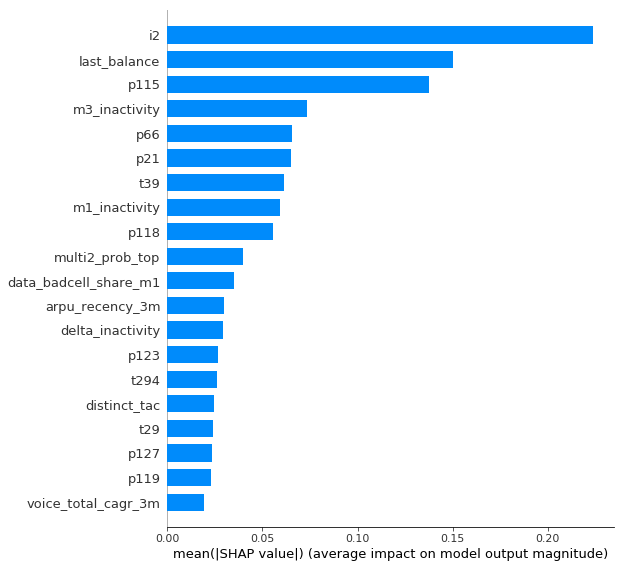

In [29]:
shap.summary_plot(shap_values, X, plot_type="bar")

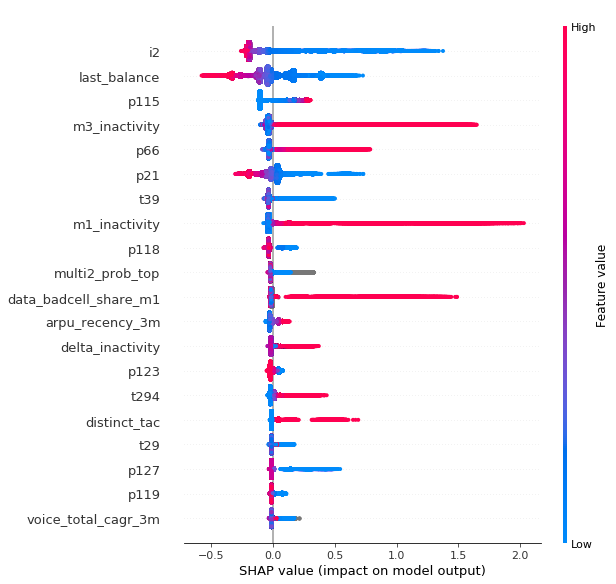

In [30]:
shap.summary_plot(shap_values, X)

In [31]:
X["market_key"] = X["market_key"].astype('category').cat.codes
X["pp_archetype"] = X["pp_archetype"].astype('category').cat.codes
X["p137"] = X["p137"].astype('category').cat.codes
X["age_category"] = X["age_category"].astype('category').cat.codes
X["price_plan_key"] = X["price_plan_key"].astype('category').cat.codes
X["operator_lst"] = X["operator_lst"].astype('category').cat.codes

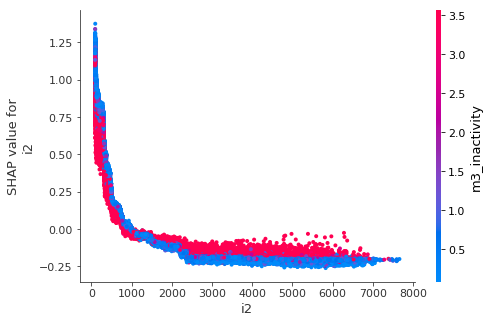

In [32]:
shap.dependence_plot('i2', shap_values, X)

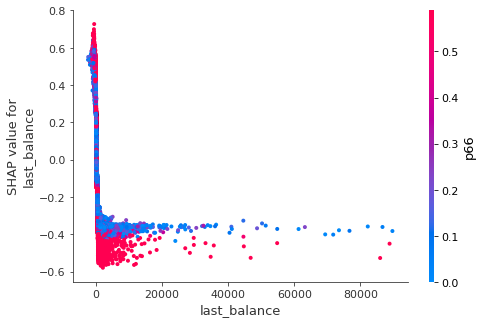

In [34]:
shap.dependence_plot('last_balance', shap_values, X)

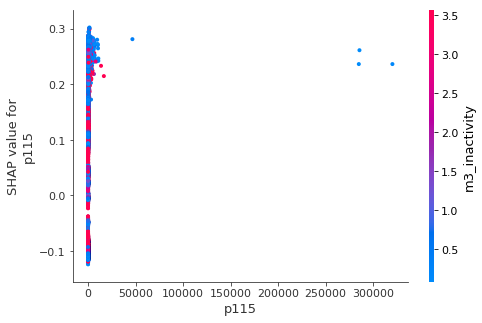

In [54]:
shap.dependence_plot('p115', shap_values, X)

In [35]:
#HIGH churn prob 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[497762,:], X.iloc[497762,:])

In [45]:
#HIGH churn prob 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[499970,:], X.iloc[499970,:])

In [50]:

print(model.predict_proba(X)[497762])
print(model.predict_proba(X)[499970])

[ 0.99446294  0.00553706]
[ 0.76263099  0.23736901]


Diff with other churn scores

In [74]:
telcom

time_key    subs_key      ban_key market_key price_plan_key  \
0       P20181231  9093266108  614660500.0        SRN      CNT7VSK2F   
1       P20181231  9032862430   42581174.0        VIP       77LEGO_3   
2       P20181231  9036190355  697671052.0        VIP      77FTTB318   
3       P20181231  9050726688  676942704.0        KMR       EV2D7_11   
4       P20181231  9065840777  419459062.0        VRN       05RAPID1   
5       P20181231  9610587070  411769197.0        VLG      04VSE3_17   
6       P20181231  9032300509   82085227.0        VIP       77VSE217   
7       P20181231  9650080310  408046912.0        SPB      SZLEGO1_1   
8       P20181231  9262656616  666488408.0        VIP      77FTTB317   
9       P20181231  9602320201   77133937.0        SPB        05V2D7C   
10      P20181231  9604418551  694966555.0        GRZ        04NSALL   
11      P20181231  9065101976   66884795.0        IVN       37ALLNWM   
12      P20181231  9618788942  691667065.0        NSK        ERAPID6   
13      P20181231  9646524252  174084884.0        IRK        ELEGO_2   
14      P20181231  9601711871   75140623.0        NNG       CLEGO_1U   
15      P20181231  9681341389  669172011.0        BGK        ELEGO_2   
16      P20181231  9633315078  202913957.0        VNG      SZLEGO1_2   
17      P20181231  9094801112  362844360.0        MAH        04V2_17   
18      P20181231  9635726958  671614587.0        BAR       ELEGO3_1   
19      P20181231  9056378306   88553560.0        YRL      76VSE2D17   
20      P20181231  9631319973  144260409.0        UFA      CNT7VSE2F   
21      P20181231  9619688387  111257186.0        PPK        EV3D7_4   
22      P20181231  9052821877  122148299.0        SPB       05VSE2D7   
23      P20181231  9096643883   17504879.0        VIP       77VSE317   
24      P20181231  9095890111  582525619.0        SPB       05VSE3D7   
25      P20181231  9038439213  446399714.0        TUL       71LEGO_2   
26      P20181231  9051220370  565729234.0        TMB       CRLEGO_1   
27      P20181231  9644927360  370190770.0        IVN       37LEGO_3   
28      P20181231  9064091073   65234834.0        VLG      04VSE_N3K   
29      P20181231  9651755925  658249468.0        VIP       77LEGO_3   
...           ...         ...          ...        ...            ...   
999970  P20181231  9685191707  667810517.0        VIP       77VSE117   
999971  P20181231  9035346055  697212535.0        VIP       77LEGO_2   
999972  P20181231  9626811945  122874622.0        SPB       NWSIMPL7   
999973  P20181231  9637224147  460031966.0        VIP        77GOXX6   
999974  P20181231  9636442175  657228555.0        VIP      77FTTB417   
999975  P20181231  9659514449  635681872.0        GRZ       04LEGO_4   
999976  P20181231  9031600024   78822008.0        VIP         VSE_XL   
999977  P20181231  9601026830   17370318.0        VRN      CRLEGO2_2   
999978  P20181231  9095114456  607321787.0        KMR         SIB3D1   
999979  P20181231  9688042216  473784640.0        VIP       77LEGO_2   
999980  P20181231  9033333246  587784063.0        TOL      CNT7VSE4F   
999981  P20181231  9607811465  115038382.0        NSK        ELEGO_2   
999982  P20181231  9059292581  453459514.0        BAR        ESIB2D2   
999983  P20181231  9601699479   29549086.0        NNG        CLEGO_3   
999984  P20181231  9053297933  435058389.0        SRT      CNT7VMC3C   
999985  P20181231  9614977294  591948154.0        STV        04V2_17   
999986  P20181231  9648278655  546448506.0        BIR        ELEGO_2   
999987  P20181231  9628703497  164292620.0        KRD        04V2_17   
999988  P20181231  9619086088  496765620.0        ORB       CLEGO_2U   
999989  P20181231  9055276641  669221499.0        VIP      77VSE1D17   
999990  P20181231  9616696221  494480598.0        VLG       04LEGO_3   
999991  P20181231  9633992644  609017618.0        NZR       04LEGO_4   
999992  P20181231  9632791762  164805810.0        KRG      45SEC0816   
999993  P20181231  9652276110  189751008.0       